# A Jupyter Notebook to aid Docking to MurD protein


This notebook implements a typical protocol for docking ligands to a target protein. It uses RDKit (http://www.rdkit.org) to generate a number of reasonable conformations for each ligand and then uses SMINA (https://sourceforge.net/projects/smina/) to do the docking. Two methods of docking are implemented, the first docks into a rigid receptor, the second sets the protein side-chains around the active site to be flexible. Bear in mind flexible docking will be much, much slower. In the optional final step the resulting docked poses are rescored using a random forest model described in https://www.nature.com/articles/srep46710.

In [1]:
import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd
IPythonConsole.ipython_3d=True
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## File location  of structures for docking and file format
First we need get the location of the input file of structures you want to dock, replace "asinexSelection.sdf" with your file. You may want to rename the output file for conformations, and the output file containing the docked structures.

The sdf file needs to have the name included in the first line of each molecule record.<br>

<code>AEM 10028511
  MOE2019           2D

 22 24  0  0  0  0  0  0  0  0999 V2000
    7.2040   -6.7290    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    6.3790   -6.7290    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0</code>

In [2]:
# File locations
sdfFilePath = 'asinexSelection.sdf' # The input file of structures to genrate conformations from
ConfoutputFilePath = 'asinexSelectionForDocking.sdf' # Output file containing conformations for docking

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

115

In [3]:
#Check that all molecules have a name
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))

## Conformation generation
We next generate conformations, this uses paralellisation code from http://www.rdkit.org/docs/Cookbook.html contributed by Andrew Dalke. We don't use all cores on a desktop machine or it might be unresponsive. If running on a cluster you should modify this.

In [4]:
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores -2

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time: 0:00:03 |################################|


In [5]:
ms = [x for x in Chem.SDMolSupplier(ConfoutputFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
for m in ms: Chem.AssignAtomChiralTagsFromStructure(m)
len(ms) # check how many conformations

520

## Docking to Protein
After generating the conformations we can now do the docking. In this example we use smina which can be downloaded from https://sourceforge.net/projects/smina/ you will need to know where smina has been installed.
The protein and ligand examples provided are taken from https://fragalysis.diamond.ac.uk/viewer/react/preview/target/MURD MURD-x0373.

Docking using smina<br>
Need protein minus the ligand in pdb format, <br>
the ligand extracted from binding site in pdb format, <br>
Conformations to be docked as sdf from conformation generation above<br>
DockedFilePath = 'All_Docked.sdf.gz' is the File for the Docked structures

In [9]:


ProteinForDocking = 'protein_minus_ligand.pdb'
LigandFromProtein = '373ligand_only.pdb'
DockedFilePath = 'All_Docked.sdf.gz'
FlexibleDockedFilePath = 'FlexDocked.sdf.gz'

In [7]:
!'/usr/local/bin/smina.osx' --cpu 10 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{DockedFilePath}'


   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.5       0.000      0.000    
2       -5.4       0.197      2.912    
3       -4.3       3.669      6.968    
4       -4.1       3.835      6.935    
5       -4.1       3.813      7.390    
6       -4.1       6.024      7.336    
7       -3.9       5.936      7.803    
8       -3.9       4.628      8.349    
9       -3.8       3.846      6.119    
Refine time 7.022
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.6       0.000      0.000    
2       -5.5       1.369      1.854    
3       -5.5       1.562      6.040    
4       -5.4       1.39

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.9       0.000      0.000    
2       -5.8       1.859      2.449    
3       -5.7       2.876      4.879    
4       -5.6       2.705      6.844    
5       -5.6       1.490      2.137    
6       -5.1       2.507      7.236    
7       -5.1       2.658      7.217    
8       -4.7       4.128      6.578    
9       -4.7       4.679      6.869    
Refine time 7.037
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.1       0.000      0.000    
2       -6.5       1.410      2.070    
3       -6.5       1.928      2.548    
4       -6.5       3.95

1       -6.2       0.000      0.000    
2       -6.1       2.651      3.468    
3       -6.1       2.662      3.896    
4       -5.9       2.270      9.027    
5       -5.7       2.977      8.597    
6       -5.5       2.227      8.696    
7       -5.3       2.416      3.215    
8       -5.1       1.388      2.158    
9       -4.8       1.357      2.352    
Refine time 7.962
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.4       0.000      0.000    
2       -6.3       2.257      9.040    
3       -6.0       1.046      1.719    
4       -5.9       1.968      2.386    
5       -5.9       2.357      3.729    
6       -5.8       2.707      3.820    
7       -5.8       1.989      8.846    
8       -5.6       3.769      8.414   

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.2       0.000      0.000    
2       -5.2       1.753      2.188    
3       -4.6       5.522      7.873    
4       -4.5       3.792      7.038    
5       -4.2       6.433      8.359    
6       -3.9       6.300      8.264    
7       -3.8       3.727      7.876    
8       -3.8       6.479      8.016    
9       -3.8       4.140      7.139    
Refine time 5.205
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.5  

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.5       0.000      0.000    
2       -4.4       0.372      2.780    
3       -4.2       3.938      6.540    
4       -4.1       4.826      9.558    
5       -4.1       3.544      5.254    
6       -4.0       3.518      5.513    
7       -4.0       4.759      9.386    
8       -3.8       3.802      7.571    
9       -3.8       2.658      6.951    
Refine time 6.152
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -3.7       0.000      0.000    
2       -3.7       0.502      2.863    
3       -3.7       2.747      5.612    
4       -3.6       2.72

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.1       0.000      0.000    
2       -5.8       3.560      6.744    
3       -5.4       3.505      5.570    
4       -5.3       3.622      5.785    
5       -5.1       2.273      2.874    
6       -5.1       4.291      6.291    
7       -4.9       3.491      6.734    
8       -4.8       5.187      8.443    
9       -4.7       9.635      11.332   
Refine time 4.045
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.1       0.000      0.000    
2       -5.0       3.510      6.637    
3       -4.9       2.715      3.679    
4       -4.5       3.69

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.0       0.000      0.000    
2       -4.9       1.272      2.386    
3       -4.8       3.677      5.929    
4       -4.6       1.491      2.013    
5       -4.5       2.905      4.031    
6       -4.3       3.279      4.825    
7       -4.3       2.814      5.227    
8       -4.2       1.715      3.079    
9       -4.2       3.686      6.806    
Refine time 5.219
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.2       0.000      0.000    
2       -4.8       4.090      6.568    
3       -4.5       1.564      2.559    
4       -4.5       3.13

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.8       0.000      0.000    
2       -4.6       4.030      8.174    
3       -4.5       3.932      6.346    
4       -4.4       3.553      7.503    
5       -4.3       8.174      9.373    
6       -4.3       3.370      6.603    
7       -4.2       4.079      7.839    
8       -4.1       4.464      6.987    
9       -4.1       7.510      9.487    
Refine time 6.091
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.8       0.000      0.000    
2       -4.0       3.212      6.484    
3       -3.9       5.463      9.007    
4       -3.8       5.48

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.5       0.000      0.000    
2       -5.2       1.565      2.256    
3       -5.0       3.963      7.546    
4       -5.0       3.627      7.352    
5       -4.7       4.337      6.332    
6       -4.4       3.646      7.096    
7       -4.3       3.587      6.864    
8       -4.3       4.559      8.254    
9       -4.2       4.122      5.434    
Refine time 4.338
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.7       0.000      0.000    
2       -5.7       1.186      1.633    
3       -4.5       4.364      6.363    
4       -4.4       3.79

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.9       0.000      0.000    
2       -5.9       1.769      2.592    
3       -5.2       3.506      5.986    
4       -4.9       2.042      2.503    
5       -4.8       3.777      8.267    
6       -4.8       3.501      6.148    
7       -4.8       4.662      7.207    
8       -4.6       7.692      9.593    
9       -4.6       3.326      5.813    
Refine time 4.524
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.3  

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.4       0.000      0.000    
2       -5.3       1.018      1.725    
3       -5.3       1.732      7.594    
4       -4.2       2.901      7.599    
5       -4.2       1.630      2.185    
6       -4.0       2.215      2.938    
7       -4.0       2.889      8.256    
8       -3.6       3.887      7.649    
9       -3.6       4.425      7.656    
Refine time 6.373
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.8  

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.6       0.000      0.000    
2       -5.3       2.836      7.843    
3       -5.1       2.389      3.151    
4       -5.0       1.477      1.799    
5       -4.4       3.098      3.576    
6       -4.2       4.115      4.618    
7       -4.2       2.649      7.802    
8       -3.8       3.947      8.289    
9       -3.8       3.461      4.778    
Refine time 5.664
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.6       0.000      0.000    
2       -5.3       2.805      7.849    
3       -5.1       2.394      3.136    
4       -5.1       1.27

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.0       0.000      0.000    
2       -4.7       5.418      7.114    
3       -4.7       1.359      2.186    
4       -4.6       3.493      4.191    
5       -4.3       2.370      6.679    
6       -4.2       4.009      6.955    
7       -4.1       6.193      8.928    
8       -4.0       4.828      6.549    
9       -3.9       5.692      8.175    
Refine time 8.287
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.1       0.000      0.000    
2       -5.6       4.517      6.582    
3       -5.4       4.555      6.568    
4       -5.3       5.02

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.6       0.000      0.000    
2       -5.5       2.505      6.591    
3       -5.0       4.761      6.945    
4       -4.6       3.657      5.970    
5       -4.5       4.533      6.672    
6       -4.5       4.687      7.379    
7       -4.4       3.756      8.336    
8       -4.4       4.262      8.282    
9       -4.3       4.218      6.319    
Refine time 3.919
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -7.1       0.000      0.000    
2       -5.7       0.666      1.507    
3       -4.8       4.177      6.254    
4       -4.6       4.14

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.6       0.000      0.000    
2       -4.3       0.135      1.910    
3       -3.8       2.921      5.867    
4       -3.6       3.778      5.665    
5       -3.5       4.734      7.039    
6       -3.4       4.687      6.923    
7       -3.1       3.021      4.893    
8       -3.1       4.965      7.206    
9       -2.9       7.605      9.703    
Refine time 3.387
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.5  

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.9       0.000      0.000    
2       -5.5       2.058      7.464    
3       -4.6       2.700      3.933    
4       -4.5       2.809      8.378    
5       -4.5       4.433      6.332    
6       -4.4       3.174      5.406    
7       -4.1       5.357      7.344    
8       -4.1       3.023      8.064    
9       -3.9       7.342      9.602    
Refine time 5.987
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.3       0.000      0.000    
2       -6.0       0.812      1.353    
3       -5.0       3.557      5.958    
4       -4.8       3.80

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.9       0.000      0.000    
2       -5.6       0.958      1.233    
3       -5.5       1.666      2.209    
4       -5.4       1.307      2.036    
5       -5.2       3.924      5.325    
6       -5.1       2.375      8.016    
7       -5.0       3.461      4.042    
8       -5.0       3.004      3.864    
9       -4.9       2.614      2.994    
Refine time 8.360
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.8  

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.7       0.000      0.000    
2       -5.4       4.373      6.684    
3       -5.0       4.749      7.009    
4       -4.6       1.932      2.508    
5       -4.5       6.207      9.057    
6       -4.4       3.780      5.769    
7       -4.2       4.739      6.783    
8       -4.1       6.805      9.563    
9       -4.0       5.181      7.246    
Refine time 4.131
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.4       0.000      0.000    
2       -5.4       1.318      2.265    
3       -4.9       1.234      2.085    
4       -4.7       4.83

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -4.8       0.000      0.000    
2       -4.8       3.835      6.617    
3       -4.7       2.195      2.755    
4       -4.6       4.435      6.697    
5       -4.6       4.134      6.373    
6       -4.4       2.016      2.359    
7       -4.4       3.464      6.561    
8       -4.4       2.628      4.053    
9       -4.4       2.731      6.795    
Refine time 7.340
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.7       0.000      0.000    
2       -6.0       0.991      2.205    
3       -5.3       1.369      7.534    
4       -5.0       1.70

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.7       0.000      0.000    
2       -5.9       1.639      2.512    
3       -5.2       3.051      6.337    
4       -5.2       2.720      6.100    
5       -5.1       3.033      6.062    
6       -4.8       3.084      6.116    
7       -4.2       3.213      6.167    
8       -4.0       4.479      6.848    
9       -3.9       4.650      7.725    
Refine time 3.170
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.6       0.000      0.000    
2       -6.2       1.700      2.081    
3       -5.1       4.059      8.007    
4       -5.0       3.02

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.3       0.000      0.000    
2       -6.2       1.399      2.386    
3       -5.8       1.331      1.636    
4       -5.3       2.747      9.085    
5       -5.1       2.143      2.733    
6       -5.0       3.716      8.776    
7       -5.0       2.466      9.105    
8       -4.9       3.368      8.673    
9       -4.7       2.400      8.556    
Refine time 8.198
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.6       0.000      0.000    
2       -5.8       2.186      2.859    
3       -5.7       2.196      3.021    
4       -5.4       2.18

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.1       0.000      0.000    
2       -4.9       1.333      2.048    
3       -4.4       3.531      6.661    
4       -4.3       4.233      6.306    
5       -4.2       3.556      5.799    
6       -4.2       2.380      3.136    
7       -3.9       4.232      7.859    
8       -3.8       7.220      9.769    
9       -3.8       4.651      7.000    
Refine time 4.487
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.1  

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.9       0.000      0.000    
2       -5.2       3.310      4.109    
3       -5.2       2.146      8.557    
4       -5.2       2.525      3.245    
5       -5.0       2.296      8.056    
6       -4.8       3.239      8.019    
7       -4.7       4.090      8.237    
8       -4.7       2.869      8.544    
9       -4.6       2.813      8.249    
Refine time 6.876
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.4       0.000      0.000    
2       -5.1       1.342      2.079    
3       -4.6       1.436      2.265    
4       -4.1       3.89

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.4       0.000      0.000    
2       -6.1       1.632      1.931    
3       -5.4       2.062      2.657    
4       -5.4       1.329      1.744    
5       -5.1       2.624      3.542    
6       -5.0       1.661      2.131    
7       -4.8       2.132      2.625    
8       -4.6       2.979      7.457    
9       -4.4       5.186      6.628    
Refine time 7.156
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.5       0.000      0.000    
2       -5.8       1.995      2.239    
3       -5.8       2.849      3.646    
4       -4.9       3.78

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.4       0.000      0.000    
2       -5.9       1.442      2.066    
3       -5.7       2.389      3.057    
4       -5.6       2.005      2.670    
5       -4.9       2.921      7.763    
6       -4.9       3.071      7.920    
7       -4.8       3.286      8.079    
8       -4.8       2.680      3.343    
9       -4.3       4.610      6.545    
Refine time 8.972
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.6       0.000      0.000    
2       -5.5       1.077      1.524    
3       -5.3       1.685      2.166    
4       -5.1       1.70

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -5.8       0.000      0.000    
2       -5.6       1.520      2.254    
3       -5.5       1.162      1.945    
4       -5.5       3.265      4.311    
5       -5.2       2.660      3.514    
6       -5.2       1.758      2.578    
7       -4.8       2.273      2.918    
8       -4.7       2.027      2.737    
9       -4.4       5.215      8.515    
Refine time 13.005
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.1       0.000      0.000    
2       -5.8       1.948      2.496    
3       -5.8       1.354      1.743    
4       -5.7       2.4

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.4       0.000      0.000    
2       -6.1       1.353      1.484    
3       -5.8       2.635      4.053    
4       -5.8       2.421      3.408    
5       -5.1       3.595      8.379    
6       -4.7       4.051      8.306    
7       -4.6       3.614      8.417    
8       -4.6       3.830      7.782    
9       -4.4       5.063      7.497    
Refine time 11.526
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -6.2       0.000      0.000    
2       -6.1       0.964      1.426    
3       -5.7       1.002      1.156    
4       -5.6       1.3

Flexible docking method, set all side chains within specified distance to flexdist_ligand to flexible
This will take an order of magnitude loner.

In [10]:
!'/usr/local/bin/smina.osx' --cpu 10 --seed 0 --autobox_ligand '{LigandFromProtein}'  --autobox_add 5 -r '{ProteinForDocking}' --flexres A:124,A:132,A:143,A:147,A:311,A:312,A:434,A:435 -l '{ConfoutputFilePath}' -o '{FlexibleDockedFilePath}'



   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Flexible residues: A:124 A:132 A:143 A:147 A:311 A:312 A:434 A:435
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.2      0.000      0.000    
2       -13.9      0.999      2.275    
3       -13.4      1.927      4.761    
4       -12.6      2.564      4.837    
5       -12.4      2.444      4.222    
6       -12.4      2.433      4.913    
7       -12.0      2.392      4.653    
8       -12.0      2.736      5.778    
9       -11.9      2.500      5.397    
Refine time 168.158
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.0      0.000      0.000    
2       -12.5      1.276      3.350    
3       -11.5      2.484      5.085    
4       -11.4      2.289      4.010    
5       -10.8      2.648      5.684    
6       -10.7      3.446      5.565    
7       -10.7      2.537      4.531    
8       -10.6      3.190      6.100    
9       -10.1      3.126      4.952    
Refine time 139.611
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -12.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.6      0.000      0.000    
2       -15.6      1.220      1.807    
3       -14.4      2.274      5.336    
4       -13.2      1.872      5.546    
5       -13.1      1.185      5.810    
6       -12.7      2.759      5.570    
Refine time 180.174
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.7      0.000      0.000    
2       -15.0      1.501      5.827    
3       -14.4      1.177      1.547    
4       -14.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.3      0.000      0.000    
2       -12.9      2.915      5.506    
3       -12.6      2.687      4.385    
4       -11.6      2.541      4.076    
5       -11.3      2.283      4.181    
6       -10.6      2.452      4.635    
7       -10.4      1.466      2.031    
8       -10.4      2.371      3.755    
Refine time 125.509
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.6      0.000      0.000    
2       -13.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.5      0.000      0.000    
2       -15.3      1.353      2.132    
3       -14.9      1.752      4.718    
4       -14.9      1.028      4.772    
5       -14.5      2.033      2.943    
6       -12.6      2.709      4.462    
7       -12.6      3.588      6.026    
Refine time 163.811
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.5      0.000      0.000    
2       -14.3      1.030      4.857    
3       -12.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.4      0.000      0.000    
2       -13.0      1.382      5.039    
3       -11.5      2.258      5.185    
4       -11.5      1.996      3.348    
5       -11.4      2.185      4.031    
6       -11.4      2.419      4.578    
7       -11.4      1.812      4.900    
8       -11.2      1.938      2.564    
9       -11.1      2.445      4.854    
Refine time 184.516
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.1      0.000      0.000    
2       -13.6      2.138      4.997    
3       -13.6      2.460      5.033    
4       -13.1      1.684      2.176    
5       -12.8      1.412      2.086    
6       -12.3      2.921      5.646    
7       -12.2      3.040      5.344    
8       -12.2      2.987      5.466    
Refine time 172.712
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.9      0.000      0.000    
2       -13.

1       -12.1      0.000      0.000    
2       -11.8      2.071      5.228    
3       -11.3      1.463      2.496    
4       -11.2      2.022      5.050    
5       -11.1      2.126      4.811    
6       -10.9      2.320      4.387    
7       -10.6      2.225      4.780    
8       -10.5      2.097      4.989    
9       -10.5      2.190      5.296    
Refine time 163.695
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.7      0.000      0.000    
2       -14.3      1.929      2.533    
3       -13.8      1.619      2.486    
4       -13.5      1.296      2.050    
5       -13.5      2.233      3.283    
6       -13.4      1.924      4.122    
7       -13.0      3.053      4.161    
8       -12.9      2.820      4.275 

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.4      0.000      0.000    
2       -14.5      1.577      2.253    
3       -13.4      1.282      2.133    
4       -12.9      2.832      5.604    
5       -12.9      1.874      5.295    
6       -12.8      2.215      4.475    
7       -12.6      2.524      4.637    
8       -12.6      1.960      5.189    
9       -12.6      2.143      3.849    
Refine time 163.247
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.9      0.000      0.000    
2       -12.5      2.625      3.992    
3       -11.6      1.480      4.360    
4       -11.4      2.396      5.201    
5       -11.4      3.157      5.776    
6       -11.3      3.039      5.081    
7       -11.2      2.638      5.069    
8       -11.2      3.579      5.168    
9       -11.2      2.925      4.310    
Refine time 137.756
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.6      0.000      0.000    
2       -13.7      0.687      1.396    
3       -13.3      1.571      4.619    
4       -12.5      2.159      4.566    
5       -12.4      2.480      4.117    
6       -12.3      2.028      3.978    
7       -12.3      2.120      5.037    
8       -12.0      2.032      3.604    
Refine time 147.551
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.7      0.000      0.000    
2       -12.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.1      0.000      0.000    
2       -13.8      2.185      4.500    
3       -13.5      3.017      5.549    
4       -13.5      2.545      4.889    
5       -12.3      3.083      4.712    
6       -12.3      2.213      4.326    
7       -12.3      3.121      5.454    
Refine time 135.289
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.6      0.000      0.000    
2       -13.7      2.783      4.135    
3       -13.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.2      0.000      0.000    
2       -13.4      1.459      2.255    
3       -12.3      2.244      4.292    
4       -12.2      1.803      4.619    
5       -12.1      2.409      5.528    
6       -12.0      2.478      5.503    
7       -12.0      2.426      5.297    
8       -11.8      2.677      4.394    
9       -11.8      2.478      4.942    
Refine time 129.559
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.7      0.000      0.000    
2       -13.7      1.576      1.963    
3       -13.5      2.523      5.242    
4       -13.4      2.141      3.275    
5       -13.4      1.741      4.611    
6       -13.3      1.362      4.473    
7       -13.2      2.075      4.124    
8       -12.9      2.145      3.686    
9       -12.6      2.003      3.297    
Refine time 161.470
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.3      0.000      0.000    
2       -15.4      1.974      5.092    
3       -14.8      1.846      5.104    
4       -14.5      1.868      5.058    
Refine time 155.421
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.3      0.000      0.000    
2       -15.0      1.208      4.933    
3       -14.8      1.271      1.887    
4       -14.3      2.825      6.234    
5       -14.3      1.639      5.179    
6       -14.

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -17.3      0.000      0.000    
2       -15.0      1.701      4.628    
3       -14.7      1.369      3.856    
Refine time 131.060
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.3      0.000      0.000    
2       -13.9      1.839      3.981    
3       -13.5      0.666      1.343    
4       -13.2      1.966      2.411    
5       -13.1      1.657      2.256    
6       -13.0      1.877      2.673    
7       -13.0      2.023      3.949    
8       -12.9      1.594      2.457    
9       -12.6      2.384      3.422    
Refine time 123.093
U

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.9      0.000      0.000    
2       -14.1      2.103      4.546    
3       -13.8      2.486      3.954    
4       -13.7      1.841      4.425    
5       -13.6      1.976      3.997    
6       -13.5      2.126      3.148    
7       -13.3      2.296      5.352    
8       -13.1      1.603      2.189    
9       -13.0      1.999      3.474    
Refine time 139.746
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.7      0.000      0.000    
2       -12.7      1.667      5.257    
3       -10.9      2.003      3.765    
4       -10.9      2.493      5.163    
5       -10.7      3.086      5.345    
Refine time 162.338
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.3      0.000      0.000    
2       -12.6      1.435      5.016    
3       -12.4      1.246      4.991    
4       -10.8      2.258      4.488    
5       -10.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.1      0.000      0.000    
2       -13.1      2.005      4.473    
3       -12.9      2.169      3.551    
4       -12.8      1.533      2.151    
5       -12.8      1.998      3.337    
6       -12.7      1.910      3.827    
7       -12.4      2.316      4.316    
8       -12.2      1.654      3.618    
9       -12.0      1.566      2.708    
Refine time 149.171
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.3      0.000      0.000    
2       -13.2      2.280      4.761    
3       -12.9      2.361      5.074    
4       -12.7      1.660      4.758    
5       -12.7      1.123      3.760    
6       -12.6      2.104      4.135    
7       -12.0      2.415      5.576    
8       -11.7      1.915      4.634    
9       -11.5      2.461      4.664    
Refine time 114.326
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.5      0.000      0.000    
2       -14.1      2.186      3.712    
3       -14.0      2.304      4.990    
4       -13.5      1.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.8      0.000      0.000    
2       -13.6      1.651      5.204    
3       -13.4      2.272      5.091    
4       -13.1      1.926      3.229    
5       -12.9      2.969      4.894    
6       -12.7      2.952      5.096    
7       -12.6      2.375      5.179    
8       -12.5      3.494      5.023    
9       -12.4      2.437      3.150    
Refine time 153.791
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.7      0.000      0.000    
2       -15.4      2.215      3.309    
3       -15.3      1.978      2.862    
4       -15.2      2.810      3.702    
5       -15.0      2.726      5.164    
6       -14.8      2.280      4.050    
7       -14.8      2.088      2.884    
8       -14.6      2.214      4.721    
9       -14.5      2.375      4.247    
Refine time 144.641
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.4      0.000      0.000    
2       -15.9      1.307      4.101    
3       -15.3      1.242      4.277    
4       -15.1      1.223      1.934    
5       -14.1      2.233      4.253    
6       -14.0      1.971      3.604    
7       -14.0      2.073      2.952    
8       -13.9      3.125      6.089    
9       -13.7      2.317      4.473    
Refine time 131.811
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -12.6      0.000      0.000    
2       -12.3      2.001      5.388    
3       -12.1      3.005      4.921    
4       -11.9      2.705      5.053    
5       -11.6      2.947      4.731    
6       -11.6      2.704      5.939    
7       -11.4      2.920      5.045    
8       -11.2      2.506      5.620    
9       -10.9      2.477      3.751    
Refine time 157.120
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.5      0.000      0.000    
2       -12.8      1.874      5.184    
3       -12.6      2.023      4.890    
4       -12.5      1.675      5.021    
5       -12.3      1.666      2.223    
6       -12.2      2.827      4.402    
7       -11.9      2.362      4.593    
8       -11.7      2.574      4.469    
9       -11.6      1.681      5.057    
Refine time 157.942
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.9      0.000      0.000    
2       -14.3      2.337      5.590    
3       -14.3      1.539      4.862    
4       -14.0      1.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.8      0.000      0.000    
2       -12.7      1.769      3.391    
3       -12.7      2.492      3.716    
4       -12.6      2.768      5.017    
5       -12.5      2.408      3.912    
6       -12.4      2.879      5.106    
7       -12.3      2.399      4.056    
8       -12.1      2.523      4.195    
9       -11.9      2.414      3.650    
Refine time 113.810
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.9      0.000      0.000    
2       -16.8      2.121      4.376    
3       -15.8      2.637      5.034    
4       -15.1      2.029      3.473    
5       -14.9      3.430      4.534    
6       -14.3      2.948      5.276    
7       -14.2      2.345      4.413    
8       -14.2      2.429      3.931    
9       -13.9      3.505      5.393    
Refine time 130.334
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.8      0.000      0.000    
2       -13.7      2.551      5.909    
3       -12.7      2.502      5.528    
4       -12.7      2.119      4.453    
5       -12.5      2.958      4.6

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.7      0.000      0.000    
2       -15.0      1.497      5.720    
3       -14.3      1.461      2.003    
4       -13.6      1.561      5.740    
5       -13.0      1.819      5.487    
Refine time 166.987
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.4      0.000      0.000    
2       -14.5      1.547      5.395    
3       -14.0      1.993      4.989    
4       -13.9      2.189      2.899    
5       -13.

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.9      0.000      0.000    
2       -13.0      2.077      3.975    
3       -12.8      2.314      4.168    
4       -12.7      2.247      4.044    
5       -12.6      2.094      4.730    
6       -12.6      2.493      4.386    
7       -12.5      2.609      5.205    
8       -12.4      2.925      5.057    
9       -12.3      1.428      4.030    
Refine time 124.800
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.4      0.000      0.000    
2       -14.4      2.042      4.107    
3       -14.1      2.943      4.444    
4       -14.0      2.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.2      0.000      0.000    
2       -15.0      1.485      2.291    
3       -14.1      2.829      4.406    
4       -13.9      1.756      2.973    
5       -13.8      2.492      3.925    
6       -13.8      1.951      3.513    
7       -13.7      2.523      4.232    
8       -13.6      2.373      4.658    
9       -13.6      1.926      3.583    
Refine time 119.974
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.2      0.000      0.000    
2       -13.8      1.685      4.273    
3       -13.2      1.951      3.443    
4       -12.4      3.414      4.684    
5       -12.2      3.338      4.862    
6       -12.1      1.673      3.620    
7       -11.8      1.413      4.018    
8       -11.4      3.346      5.539    
9       -11.3      1.429      4.270    
Refine time 128.378
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.8      0.000      0.000    
2       -13.6      1.595      3.004    
3       -13.2      2.184      3.922    
4       -13.0      2.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.3      0.000      0.000    
2       -12.9      1.532      1.962    
3       -11.7      2.283      5.137    
4       -11.2      1.552      1.875    
5       -11.2      2.917      5.314    
6       -10.8      2.418      3.716    
7       -10.7      3.274      4.714    
8       -10.7      2.699      5.531    
9       -10.5      2.862      5.221    
Refine time 172.118
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -12.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.7      0.000      0.000    
2       -14.4      2.167      3.633    
3       -14.2      1.451      5.009    
4       -14.2      2.946      4.257    
5       -13.6      2.487      4.441    
6       -13.4      1.858      3.527    
7       -13.4      2.514      3.348    
8       -13.4      1.324      5.312    
9       -13.3      2.870      5.962    
Refine time 164.262
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -15.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -16.6      0.000      0.000    
2       -15.6      1.004      4.484    
3       -15.6      1.360      4.703    
4       -14.5      1.332      2.070    
5       -13.7      2.370      5.254    
6       -13.6      2.781      5.390    
Refine time 163.270
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.7      0.000      0.000    
2       -13.7      0.849      1.663    
3       -13.0      2.074      4.357    
4       -12.

***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.4      0.000      0.000    
2       -12.6      3.123      5.481    
3       -12.6      1.531      3.042    
4       -12.5      2.212      3.798    
5       -12.5      3.035      5.129    
6       -12.3      2.870      4.267    
7       -12.1      3.325      5.274    
8       -12.0      3.237      5.130    
9       -11.9      2.859      4.993    
Refine time 197.118
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.3      0.000      0.000    
2       -13.5      1.062      1.827    
3       -12.6      2.428      5.434    
4       -12.2      2.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -13.6      0.000      0.000    
2       -12.2      1.740      2.786    
3       -11.8      2.360      5.579    
4       -11.7      2.357      5.701    
5       -11.7      2.278      5.652    
6       -10.9      2.563      4.680    
7       -10.7      2.336      3.798    
8       -10.7      2.714      5.358    
Refine time 213.791
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.1      0.000      0.000    
2       -13.

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.0      0.000      0.000    
2       -12.9      2.539      5.439    
3       -12.1      2.384      5.375    
4       -11.7      2.808      5.168    
5       -11.3      2.165      4.003    
6       -11.1      2.718      4.463    
Refine time 197.256
Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1       -14.0      0.000      0.000    
2       -13.1      1.729      2.339    
3       -12.8      2.241      4.992    
4       -12.

## Rescoring using Random Forest Model

Optional, 
Rescore using a random forest model described in https://www.nature.com/articles/srep46710

Download from https://github.com/oddt/rfscorevs
You will need the path to the binary

Path to protein containing ligand in pdb format<br>
protein_plus_373ligand from Diamond<br>
File to store rescored resukts

In [11]:


TargetProtein = 'protein_plus_373ligand.pdb'
scoreResults = 'DockedRescored.csv'

In [12]:
!/usr/local/bin/rf-score-vs --receptor '{TargetProtein}' '{DockedFilePath}' -o csv -O '{scoreResults}' --field name --field RFScoreVS_v2

In [13]:

docked_df = PandasTools.LoadSDF(DockedFilePath,molColName='Molecule')

In [14]:
#docked_df.head(n=5)

In [15]:
scores_df = pd.read_csv(scoreResults)

In [16]:
#scores_df.head(n=5)



In [17]:
results_df = pd.concat([docked_df, scores_df], axis=1)

ID                                           Molecule  \
0  ART 15342099  <img src="data:image/png;base64,iVBORw0KGgoAAA...   
1  ART 15342099  <img src="data:image/png;base64,iVBORw0KGgoAAA...   
2  ART 15342099  <img src="data:image/png;base64,iVBORw0KGgoAAA...   
3  ART 15342099  <img src="data:image/png;base64,iVBORw0KGgoAAA...   
4  ART 15342099  <img src="data:image/png;base64,iVBORw0KGgoAAA...   

  minimizedAffinity          name  RFScoreVS_v2  
0          -5.26767  ART 15342099      6.127652  
1          -5.05578  ART 15342099      6.112676  
2          -4.83187  ART 15342099      6.085660  
3          -4.74720  ART 15342099      6.063921  
4          -4.72279  ART 15342099      6.109961
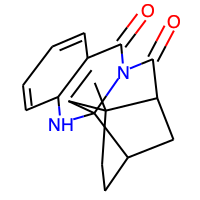
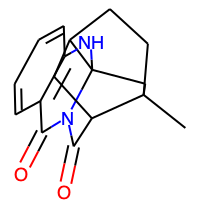
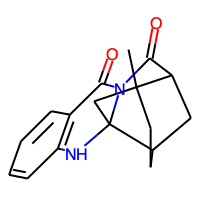
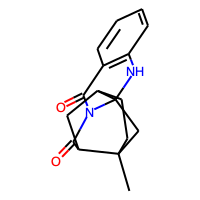
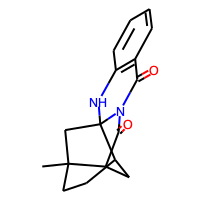

In [18]:
results_df.head(5)

## Saving the results
Now combine rescored file with docked structure file and export to "Alldata.sdf.gz" this is a big file so export compressed

In [19]:
combinedResults = 'Alldata.sdf.gz'

In [20]:
PandasTools.WriteSDF(results_df, combinedResults, molColName="Molecule", idName="ID", properties=list(results_df.columns))